# Linear Regression

# 1. Importing libraries and data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score

In [18]:
# Config
CSV_PATH = r'/Users/davidscheider/anaconda_projects/Bitcoin Analytics/02 Data/Prepared Data/btc_clean.csv'
TARGET_COL = 'Close'         # use 'Close' as the price
FUTURE_DAYS = 365 * 3        # extend regression this many days into the future
N_SPLITS = 5                 # for time-series cross-validated R^2 in log-space
MIN_POSITIVE_EPS = 1e-9      # guard for logs

In [19]:
# 1) Load & prep
df = pd.read_csv(CSV_PATH, index_col=False)

In [20]:
# ensure expected columns exist
needed = {'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'}
missing = needed - set(df.columns)
if missing:
    raise ValueError(f'Missing columns in CSV: {missing}')

In [21]:
# convert timestamp to datetime (seconds since epoch)
df['Date'] = pd.to_datetime(df['Timestamp'], unit='s', utc=True).dt.tz_convert('UTC')  # keep UTC
df = df.sort_values('Date').drop_duplicates(subset=['Date']).reset_index(drop=True)

In [22]:
# 2) Build time feature: elapsed days since first observation
t0 = df['Date'].iloc[0]
df['t_days'] = (df['Date'] - t0).dt.total_seconds() / 86400.0

In [23]:
# keep only strictly positive time and positive prices (required for logs)
mask = (df['t_days'] > 0) & (df[TARGET_COL] > 0)
data = df.loc[mask, ['Date', 't_days', TARGET_COL]].copy()

In [24]:
# log-transform features/target for power-law fit
data['log_t'] = np.log(data['t_days'] + MIN_POSITIVE_EPS)
data['log_y'] = np.log(data[TARGET_COL] + MIN_POSITIVE_EPS)

X = data[['log_t']].values
y = data['log_y'].values

In [25]:
# 3) Fit linear regression in log-log space
lin = LinearRegression()
lin.fit(X, y)

LinearRegression()

In [26]:
# parameters: y = a + b * log_t  => price ≈ exp(a) * t^b
a = float(lin.intercept_)
b = float(lin.coef_[0])
k = float(np.exp(a))

In [27]:
# In-sample R^2 in log-space
y_hat_in = lin.predict(X)
r2_in = r2_score(y, y_hat_in)

In [28]:
# Time-series CV R^2 (optional but informative)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
cv_scores = []
for tr_idx, te_idx in tscv.split(X):
    lin_cv = LinearRegression().fit(X[tr_idx], y[tr_idx])
    y_pred_cv = lin_cv.predict(X[te_idx])
    cv_scores.append(r2_score(y[te_idx], y_pred_cv))
r2_cv_mean = float(np.mean(cv_scores))
r2_cv_std = float(np.std(cv_scores))

print(f'Power-law parameters:')
print(f'  b (exponent)       = {b: .4f}')
print(f'  k (scale)          = {k: .6g}')
print(f'Log-space R^2 (fit):  {r2_in: .4f}')
print(f'Log-space R^2 (TS CV, {N_SPLITS} splits): {r2_cv_mean: .4f} ± {r2_cv_std: .4f}')

Power-law parameters:
  b (exponent)       =  2.4933
  k (scale)          =  2.22422e-05
Log-space R^2 (fit):   0.8515
Log-space R^2 (TS CV, 5 splits): -4.5300 ±  3.8673


In [29]:
# 4) Create future timeline for extrapolation
last_date = data['Date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    end=last_date + pd.Timedelta(days=FUTURE_DAYS),
    freq='D',
    tz='UTC'
)

# convert to "days since t0" as floats
future_t_days = (future_dates - t0) / pd.Timedelta(days=1)

# log-transform feature for the model (ensure 2D array)
future_log_t = np.log(future_t_days.to_numpy(dtype=float) + MIN_POSITIVE_EPS).reshape(-1, 1)


In [30]:
# predictions (back-transform)
hist_pred_log = lin.predict(X)
hist_pred = np.exp(hist_pred_log)

future_pred_log = lin.predict(future_log_t)
future_pred = np.exp(future_pred_log)

/var/folders/bz/7hwgnc95287cp83lwy4gfzth0000gn/T/ipykernel_19075/2038529137.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


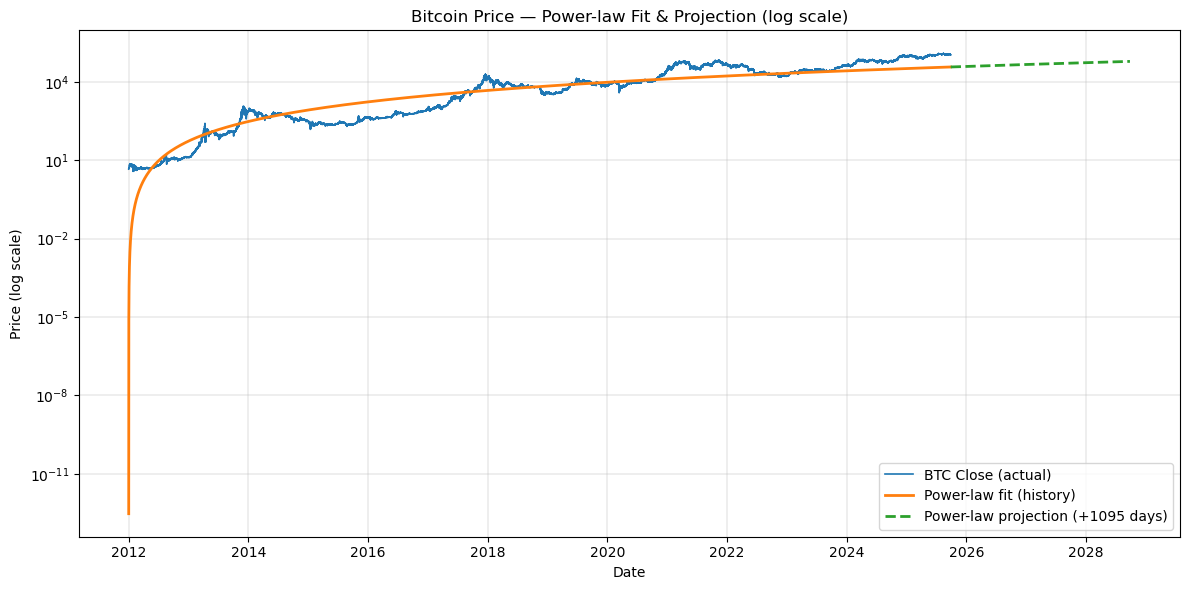

In [31]:
# 5) Plot: actual prices + fitted curve + future extension
plt.figure(figsize=(12, 6))
# historical actuals
plt.plot(data['Date'], data[TARGET_COL].values, label='BTC Close (actual)', linewidth=1.2)
# fitted curve over history
plt.plot(data['Date'], hist_pred, label='Power-law fit (history)', linewidth=2)
# future extension
plt.plot(future_dates, future_pred, linestyle='--', label=f'Power-law projection (+{FUTURE_DAYS} days)', linewidth=2)

plt.yscale('log')  # prices span orders of magnitude
plt.xlabel('Date')
plt.ylabel('Price (log scale)')
plt.title('Bitcoin Price — Power-law Fit & Projection (log scale)')
plt.legend()
plt.grid(True, which='both', linewidth=0.3)
plt.tight_layout()
plt.show()

In [33]:
# 6) produce a tidy table with a few future predictions
preview = pd.DataFrame({
    'Date': future_dates[:10],
    'Projected_Close': future_pred[:10]
})
print('\nFirst 10 projected daily prices:')
print(preview.to_string(index=False))


First 10 projected daily prices:
                     Date  Projected_Close
2025-09-26 23:57:00+00:00     37456.723046
2025-09-27 23:57:00+00:00     37475.338360
2025-09-28 23:57:00+00:00     37493.959214
2025-09-29 23:57:00+00:00     37512.585608
2025-09-30 23:57:00+00:00     37531.217543
2025-10-01 23:57:00+00:00     37549.855019
2025-10-02 23:57:00+00:00     37568.498037
2025-10-03 23:57:00+00:00     37587.146598
2025-10-04 23:57:00+00:00     37605.800702
2025-10-05 23:57:00+00:00     37624.460350


An R2 of 0.8515 indicates that the linear regression actually has predicitive value. However, Bitcoin’s price time series is non-stationary, heteroskedastic, and highly nonlinear. Linear regression assumes none of those things — it assumes stability and linearity — so its fit is statistically invalid for long-term prediction.
The projected price predictions also don't make a ton of sense. There seems to be a problem with the initial data that is overrepresented in the chart.